In [1]:
from scripts.open_preprocess_racmo import *
from scripts.paths import *
from scripts.dicts import *

# from sum_freshwater_func import *

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np

import plotly.express as px

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


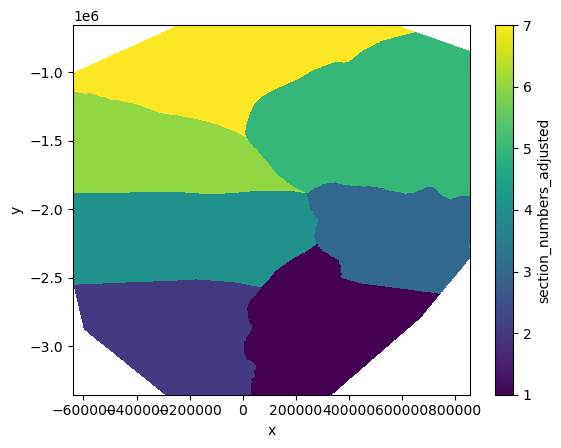

In [2]:
fname = pathIMAU02 + "RACMO2.3p2/FGRN055/Downscaling_GR/masks1k.nc"
mask1 = xr.open_dataset(fname)

fname = (
    pathIMAU02
    + "RACMO2.3p2/FGRN055/Downscaling_GR/Mask_adjusted_section_numbers_slater_may24_copy.nc"
)
mask_regions = xr.open_dataset(fname)

mask_regions['section_numbers_adjusted'].plot()

make regions data array

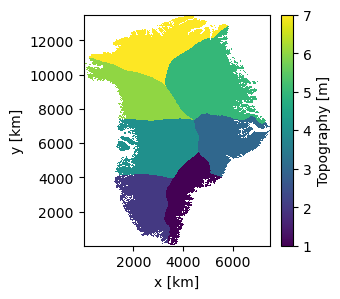

In [3]:
da_regions = xr.zeros_like(mask1['LSM']) 
da_regions.values = (mask1['LSM'].values*mask_regions['section_numbers_adjusted'].values)
da_regions = da_regions.where(da_regions>0)
da_regions.name = 'region'
da_regions.plot.imshow(figsize=(3,3))

# open racmo precip annual

In [20]:
precipRACMO1kmAnnual = pathIMAU02 + "RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
dsprecipRACMO1kmAnnual = xr.open_mfdataset(precipRACMO1kmAnnual, decode_times=False)


# Extract the time values (years since reference)
years_since_ref = dsprecipRACMO1kmAnnual['time'].values
ref_year = 1958
actual_years = ref_year + years_since_ref.astype(int)
new_dates = np.array([np.datetime64(f'{year}-01-01') for year in actual_years])
dsprecipRACMO1kmAnnual['time'] = new_dates

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_25947/4105770296.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dsprecipRACMO1kmAnnual['time'] = new_dates
/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_25947/4105770296.py:10: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the

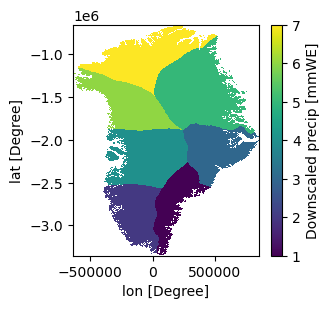

In [21]:
dsprecipRACMO1kmAnnual['regions'] = xr.zeros_like(dsprecipRACMO1kmAnnual['precipcorr'].isel(time=0))
dsprecipRACMO1kmAnnual['regions'].values = da_regions.values

dsprecipRACMO1kmAnnual['regions'].plot.imshow(figsize=(3,3))


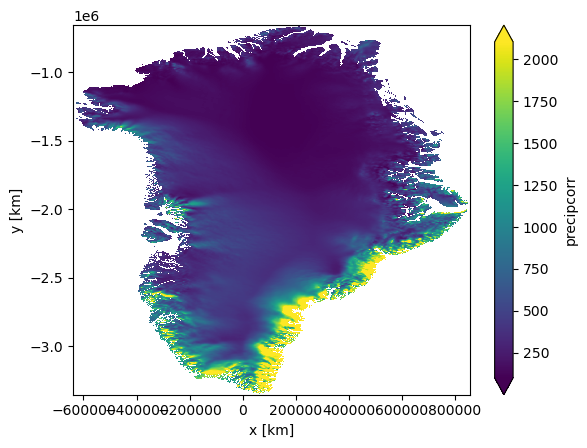

In [ ]:
dsprecipRACMO1kmAnnual['precipcorr'].where(dsprecipRACMO1kmAnnual['regions']>=1).mean(dim='time').plot(robust=True)

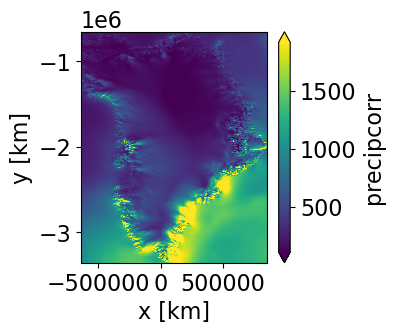

In [ ]:
dsprecipRACMO1kmAnnual.sel(time=slice(start,end)).mean(dim='time')['precipcorr'].plot.imshow(robust=True, figsize=(3,3))

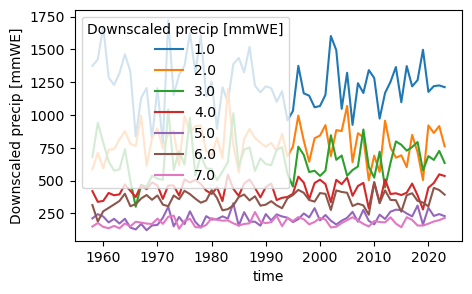

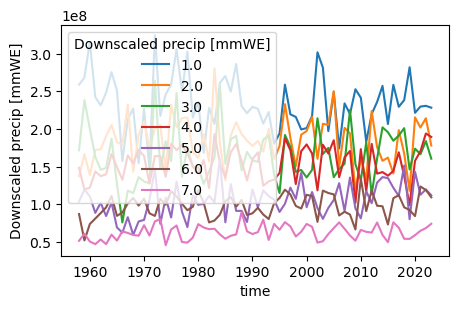

In [ ]:
dsprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual['precipcorr'].groupby(dsprecipRACMO1kmAnnual['regions']).mean()
dsprecipRACMO1kmAnnual_mean_region.plot.line(x='time', figsize=(5,3))
plt.show()

dsprecipRACMO1kmAnnual_sum_region = dsprecipRACMO1kmAnnual['precipcorr'].groupby(dsprecipRACMO1kmAnnual['regions']).sum()
dsprecipRACMO1kmAnnual_sum_region.plot.line(x='time', figsize=(5,3))

In [ ]:
start = '1990-01-01'
end = '2005-01-01'

In [ ]:
dfprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual_mean_region.sel(time=slice(start,end)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_mean_region['Basins'] = dfprecipRACMO1kmAnnual_mean_region['regions'].astype(int).map(dict_sections)
# dfprecipRACMO1kmAnnual_mean_region.to_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_mean_precip_per_region_1990-2022.csv')
dfprecipRACMO1kmAnnual_sum_region = dsprecipRACMO1kmAnnual_sum_region.sel(time=slice(start,end)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_sum_region['Basins'] = dfprecipRACMO1kmAnnual_sum_region['regions'].astype(int).map(dict_sections)
# dfprecipRACMO1kmAnnual_sum_region.to_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_sum_precip_per_region_1990-2022.csv')

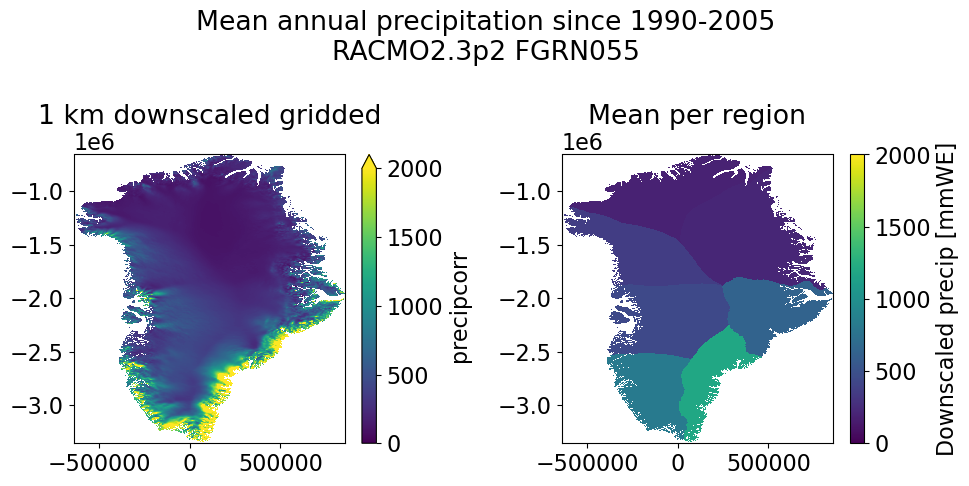

In [ ]:
import xarray as xr

# Assuming dsprecipRACMO1kmAnnual is your DataArray and you want to replace all instances of `old_value` with `new_value`
dsprecipRACMO1kmAnnual['precipmean'] = dsprecipRACMO1kmAnnual['regions'].copy(deep=True)
for i in range(7):
    old_value = dfprecipRACMO1kmAnnual_mean_region['regions'][i]
    new_value = dfprecipRACMO1kmAnnual_mean_region['precipcorr'][i]
    dsprecipRACMO1kmAnnual['precipmean'] = dsprecipRACMO1kmAnnual['precipmean'].where(dsprecipRACMO1kmAnnual['precipmean'] != old_value, new_value)

fig,axs = plt.subplots(1,2,figsize=(10,5))
dsprecipRACMO1kmAnnual['precipmean'].plot.imshow(ax=axs[1], vmin=0, vmax=2000)
dsprecipRACMO1kmAnnual.where(dsprecipRACMO1kmAnnual['regions']>=1).sel(time=slice(start,end)).mean(dim='time')['precipcorr'].plot.imshow( ax=axs[0], vmin=0, vmax=2000)

# remove y label xlabel
axs[0].set_ylabel('')
axs[1].set_ylabel('')
axs[0].set_xlabel('')
axs[1].set_xlabel('')

# set title
axs[0].set_title('1 km downscaled gridded')
axs[1].set_title('Mean per region')
fig.suptitle(f'Mean annual precipitation since {start[:4]}-{end[:4]}'+'\nRACMO2.3p2 FGRN055')
fig.tight_layout()

In [ ]:

# dfprecipRACMO1kmAnnual_mean_region = pd.read_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_mean_precip_per_region_1990-2022.csv')
# dfprecipRACMO1kmAnnual_sum_region = pd.read_csv(pathDataTemp+'RACMO2.3p2_FGRN055_1km_sum_precip_per_region_1990-2022.csv')


In [ ]:
df_per_region_abs = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_absolute_1990_2022.csv')
df_per_region_rel = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_relative_1990_2022.csv')

# df_per_region_rel = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_relative_1990_2005.csv')

# df_per_region_rel = pd.read_csv(pathDataProcessed + 'Mean_Freshwater_components_annual_per_region_relative_2006_2022.csv')


month  Solid ice discharge  Precipitation  Tundra runoff  GIC runoff  \
0       1                 81.3           11.3            3.3         0.3   
1       2                 83.5            9.9            2.5         0.2   
2       3                 84.8            7.8            3.1         0.3   
3       4                 74.3            7.3           13.6         0.5   
4       5                 49.2            4.5           34.5         1.4   
5       6                 23.3            1.8           29.2         6.4   
6       7                 12.8            1.0           12.5        12.7   
7       8                 19.8            2.2           11.7        11.2   
8       9                 50.9            7.9           12.2         4.7   
9      10                 73.6           10.6            9.3         0.7   
10     11                 78.1           10.2            7.3         0.3   
11     12                 81.5            9.5            4.8         0.3   
12  Total                 39.8            4.5           14.5         6.7   

    GrIS runoff  Basal melt  
0           0.9         3.0  
1           0.8         3.1  
2           0.9         3.1  
3           1.6         2.8  
4           8.4         2.0  
5          37.9         1.5  
6          60.0         1.0  
7          53.6         1.5  
8          21.8         2.6  
9           2.9         2.8  
10          1.2         2.9  
11          1.0         3.0  
12         32.7         1.9

In [ ]:
dfprecipRACMO1kmAnnual_mean_region = dsprecipRACMO1kmAnnual_mean_region.sel(time=slice(start,end)).mean(dim='time').to_dataframe().round().reset_index()
dfprecipRACMO1kmAnnual_mean_region['Basins'] = dfprecipRACMO1kmAnnual_mean_region['regions'].astype(int).map(dict_sections)
dfprecipRACMO1kmAnnual_mean_region

regions  precipcorr Basins
0      1.0      1195.0     SE
1      2.0       820.0     SW
2      3.0       636.0     CE
3      4.0       444.0     CW
4      5.0       218.0     NE
5      6.0       367.0     NW
6      7.0       188.0     NO

Absolute

In [ ]:

df_mean_precip_abs_flux = pd.merge(df_per_region_abs, dfprecipRACMO1kmAnnual_sum_region)
df_abs = df_mean_precip_abs_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'Flux'})

# for both drop column 'regions'
# df_abs = df_abs.drop(columns=['regions'])


In [ ]:
label_rename = {
    'precipcorr': 'Precipitation (mm yr<sup>-1</sup> km<sup>-2</sup>)', 
    'Flux': 'Flux (Gt yr<sup>-1</sup>)',
}


fig = px.scatter(df_abs.rename(columns=label_rename), x=label_rename['precipcorr'], y=label_rename['Flux'],color='FW component', facet_col='FW component',facet_col_wrap=3,trendline='ols', facet_col_spacing=0.05, facet_row_spacing=0.15, template='plotly_white', text='Basins')
fig.update_traces(textposition='top center')
fig.update_yaxes(matches=None)
results = px.get_trendline_results(fig)


# Assuming 'results' contains the trendline results and 'fig' is your Plotly Express figure

# Initialize a list to hold correlation coefficients
correlation_coefficients = []
r_squared_values = []
names = []

# Calculate correlation coefficients from the R-squared values
for i, result in enumerate(results.px_fit_results):
    FW_comp = results['FW component'][i]
    names.append(FW_comp)
    correlation_coefficient = np.sqrt(result.rsquared)
    correlation_coefficients.append(correlation_coefficient)
    r_squared = result.rsquared
    correlation_coefficient = np.sqrt(r_squared)
    correlation_coefficients.append(correlation_coefficient)
    r_squared_values.append(r_squared)
    print(f"{FW_comp}: R² = {r_squared:.2f}")



def add_annotations(fig, r_squared_values, correlation_coefficients):
    for i, annotation in enumerate(fig.layout.annotations):
        # new_text = f"{annotation.text}<br>{names[i]}<br> R²: {r_squared_values[i]:.2f}, Corr: {correlation_coefficients[i]:.2f}"
        # annotation.text = new_text
        annotation.text = "{}".split("=")[1]
fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))
# Add the annotations to the plot
# add_annotations(fig, r_squared_values, correlation_coefficients)

# split tile at "="
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].text = fig.layout.annotations[i].text.split("=")[1]

fig.update_yaxes(range=[0, None])  # Y-axis starts at 0
fig.update_xaxes(range=[0, None])
# change y and x labels


# fig.write_image(pathFigures+'scatter_precip_corr_FW_components_abs_Gtyr-1.png', width=1000, height=800, scale=2)
fig.show()

Solid Ice Discharge: R² = 0.23
Liquid Runoff Ice Sheet: R² = 0.50
Liquid Runoff Tundra: R² = 0.26
Liquid Runoff Ice Caps: R² = 0.17
Precipitation Fjords: R² = 0.73
Precipitation Fjords CARRA: R² = 0.66
regions: R² = 0.97


Relative

In [ ]:
df_per_region_rel_reform = df_per_region_rel.rename(columns={'Unnamed: 0':'FW component'}).set_index('FW component').T.reset_index().rename(columns={'index':'Basins'})
df_mean_precip_rel_flux = pd.merge(df_per_region_rel_reform, dfprecipRACMO1kmAnnual_sum_region)
df_rel = df_mean_precip_rel_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'%'})
df_rel['%'] = df_rel['%']*100

In [ ]:
label_rename = {
    'precipcorr': 'Precipitation (mm yr<sup>-1</sup>)', 
    '%': '% total input',
}

fig = px.scatter(df_rel.rename(columns=label_rename), x=label_rename['precipcorr'], y=label_rename['%'],color='FW component', facet_col='FW component',facet_col_wrap=3,trendline='ols', facet_col_spacing=0.05, facet_row_spacing=0.15, template='plotly_white', text='Basins')
fig.update_traces(textposition='top center')
fig.update_yaxes(matches=None, range=[0, None])
results = px.get_trendline_results(fig)

fig.update_yaxes()  # Y-axis starts at 0
fig.update_xaxes(range=[0, None])

# Assuming 'results' contains the trendline results and 'fig' is your Plotly Express figure

# Initialize a list to hold correlation coefficients
correlation_coefficients = []
r_squared_values = []
names = []

# Calculate correlation coefficients from the R-squared values
for i, result in enumerate(results.px_fit_results):
    FW_comp = results['FW component'][i]
    names.append(FW_comp)

    r_squared = result.rsquared
    r_squared_values.append(r_squared)
    print(f"{FW_comp}: R² = {r_squared:.2f}")


fig.for_each_yaxis(lambda axis: axis.update(showticklabels=True))
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].text = fig.layout.annotations[i].text.split("=")[1]

# change y and x labels


# fig.write_image(pathFigures+'scatter_precipSUM_corr_FW_components_rel.png', width=1000, height=600, scale=2)
fig.show()

Solid Ice Discharge: R² = 0.01
Liquid Runoff Ice Sheet: R² = 0.02
Liquid Runoff Tundra: R² = 0.00
Liquid Runoff Ice Caps: R² = 0.10
Precipitation Fjords: R² = 0.44
Precipitation Fjords CARRA: R² = 0.42
regions: R² = 0.98


In [ ]:
df_rel[df_rel['FW component'] == 'Solid Ice Discharge']

precipcorr Basins         FW component          %
0   225177088.0     SE  Solid Ice Discharge  56.472381
7   191923328.0     SW  Solid Ice Discharge  11.301755
14  161110048.0     CE  Solid Ice Discharge  43.144793
21  157157184.0     CW  Solid Ice Discharge  47.026051
28  106574648.0     NE  Solid Ice Discharge  22.365931
35  102174360.0     NW  Solid Ice Discharge  69.743462
42   65070416.0     NO  Solid Ice Discharge  30.182850

In [ ]:
# Solid Ice Discharge	Liquid Runoff Ice Sheet	Liquid Runoff Tundra	Liquid Runoff Ice Caps	Precipitation Fjords	Precipitation Fjords CARRA

short_dict = {
    'Solid Ice Discharge': 'SID',
    'Liquid Runoff Ice Sheet': 'L_GrIS',
    'Liquid Runoff Tundra': 'L_Tundra',
    'Liquid Runoff Ice Caps': 'L_GIC',
    'Precipitation Fjords': 'P_RACMO',
    'Precipitation Fjords CARRA': 'P_CARRA',
}

            


In [ ]:
import pandas as pd

def style_dataframe(df, short_dict):
    """
    Styles the DataFrame with a background gradient, sets a caption, and formats numbers.
    
    Parameters:
    - df: DataFrame to be styled.
    - short_dict: Dictionary for renaming index and columns.
    
    Returns:
    - A pandas.io.formats.style.Styler object with the specified styles applied.
    """
    return df.rename(index=short_dict, columns=short_dict).style.background_gradient(cmap='PRGn',vmin=-1, vmax=1).set_caption("Correlation Matrix").format("{:.2f}")

style_dataframe(df_per_region_rel.set_index(["Unnamed: 0"]).T.corr(), short_dict)

In [ ]:

df_mean_precip_abs_flux = pd.merge(df_per_region_abs, dfprecipRACMO1kmAnnual_sum_region)
df_abs = df_mean_precip_abs_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'Flux'})

# for both drop column 'regions'
# df_abs = df_abs.drop(columns=['regions'])


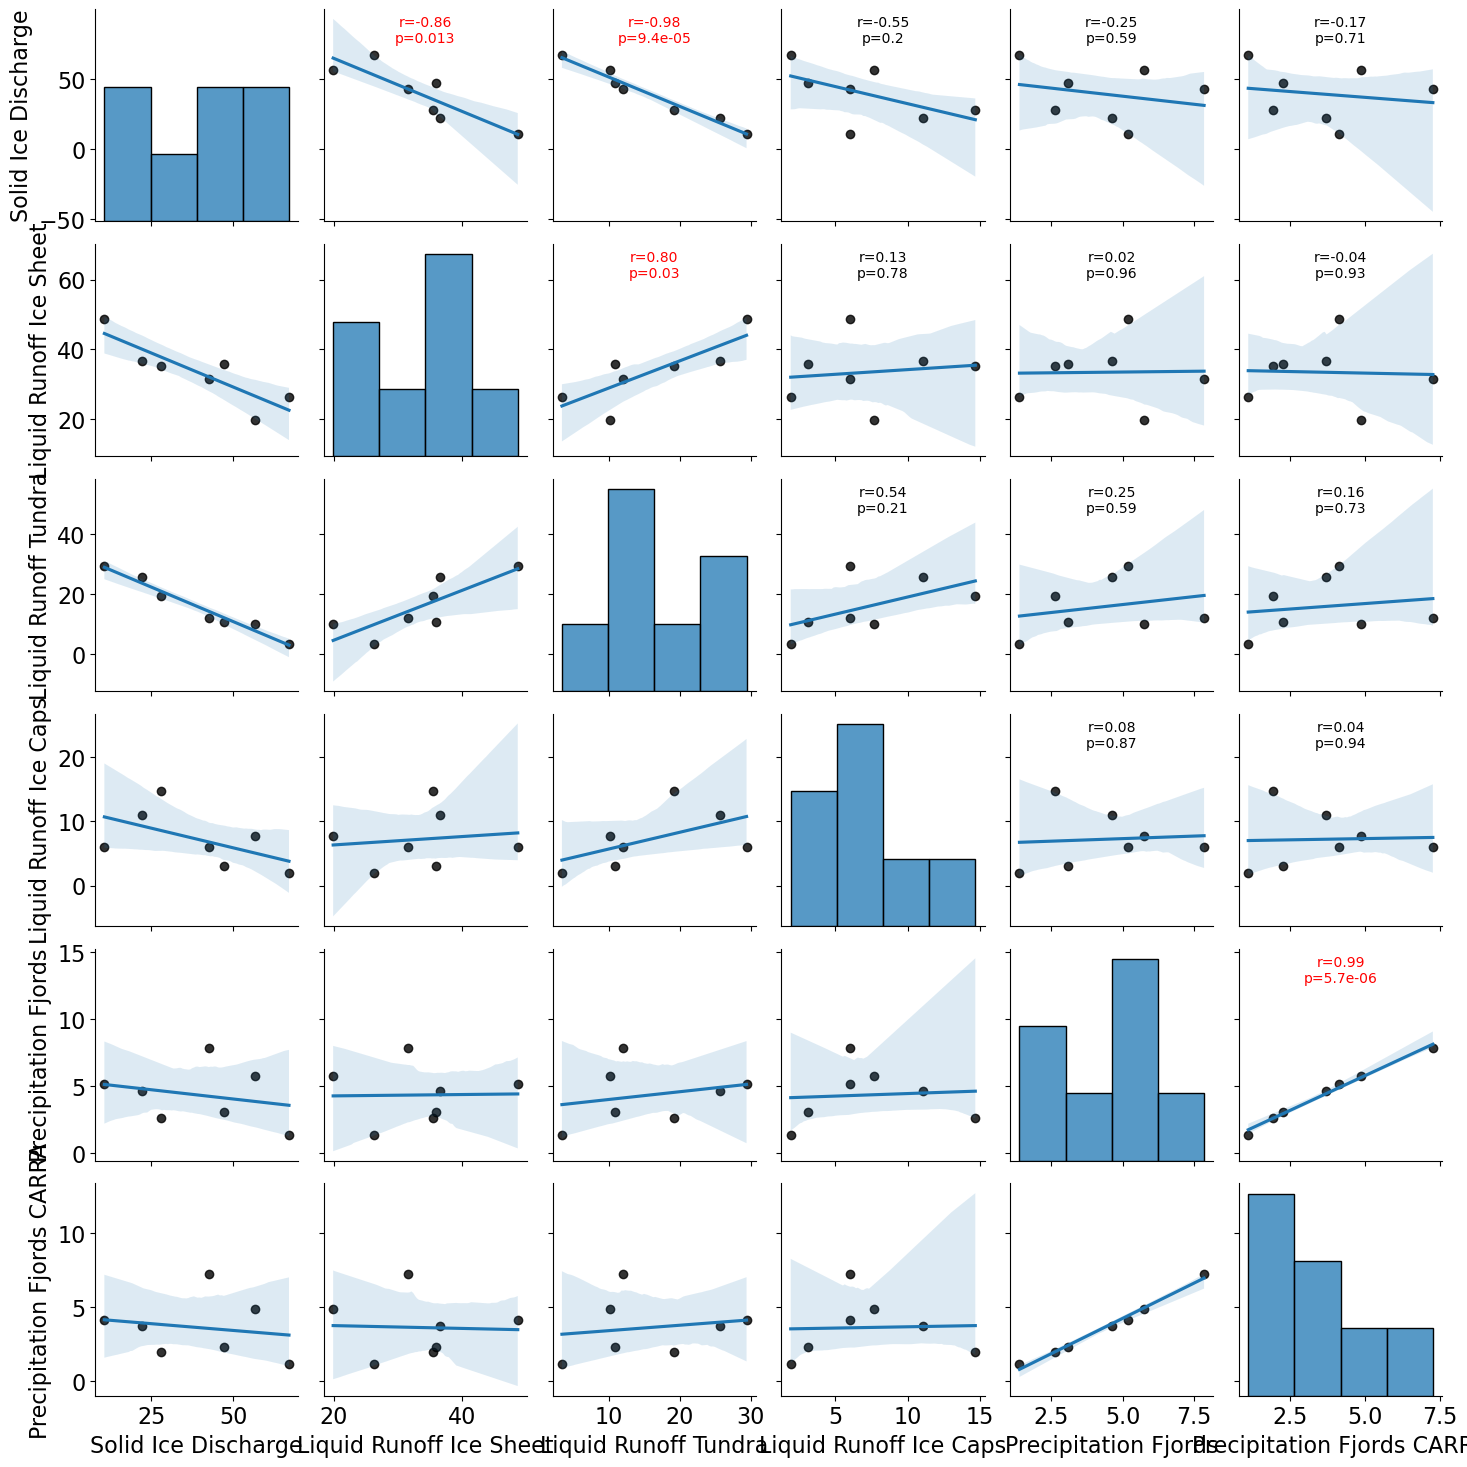

In [ ]:
def create_pair_plot(df):
    pair_plot = sns.pairplot(df, kind='reg',  plot_kws={ 'scatter_kws': {'color': 'black'}})

    # Function to calculate correlation and p-value
    def corrfunc(x, y):
        r, p = pearsonr(x, y)
        return r, p

    # Add correlation coefficients and p-values to the plot
    for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
        x = df.iloc[:, j]
        y = df.iloc[:, i]
        r, p = corrfunc(x, y)
        

        # Choose color based on p-value
        color = 'red' if p < 0.05 else 'black'
       
        # Display correlation coefficient and p-value
        pair_plot.axes[i, j].annotate(f'r={r:.2f}\np={p:.2g}', 
                                    xy=(0.5, 0.9), 
                                    xycoords='axes fraction', 
                                    ha='center', 
                                    va='center', 
                                    fontsize=10, 
                                    color=color)
    return pair_plot

df = df_per_region_rel.rename(columns={'Unnamed: 0':'FW'}).set_index('FW').T *100
create_pair_plot(df)


In [ ]:
# make an array where you have strings with column name + "/SID"
divide_SID = df.columns + "/SID"
divide_SID

Index(['Solid Ice Discharge/SID', 'Liquid Runoff Ice Sheet/SID',
       'Liquid Runoff Tundra/SID', 'Liquid Runoff Ice Caps/SID',
       'Precipitation Fjords/SID', 'Precipitation Fjords CARRA/SID'],
      dtype='object', name='FW')

# Melt over Accumulation

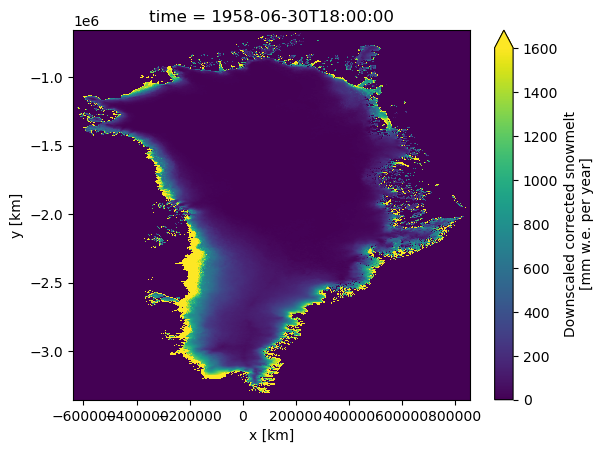

In [4]:
df_snow_melt = xr.open_dataset("/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowmelt.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz")
df_snow_melt.isel(time=0)['snowmeltcorr'].plot(robust=True)

In [10]:
import os
import xarray as xr
import gzip
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_first_timestep_in_directory(directory):
    datasets = {}
    # Loop through all files in the specified directory
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".nc.gz") or filename.endswith(".nc"):
            # Full path to the file
            filepath = os.path.join(directory, filename)
            
            # Create a temporary unzipped file path
   
            # Open the dataset using xarray
            ds = xr.open_dataset(filepath, decode_times=False)
            
            # Get the first time step of the single variable in the dataset
            variable_name = list(ds.data_vars.keys())[0]  # Assumes only one variable per file
            datasets[variable_name] = ds
            ds.isel(time=0)[variable_name].plot.imshow(robust=True, figsize=(3,3))
            
            # Display the plot
            plt.title(f"{variable_name}")
            plt.show()
    return datasets


  0%|          | 0/9 [00:00<?, ?it/s]

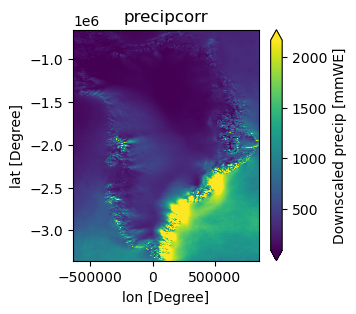

 11%|█         | 1/9 [00:07<01:00,  7.61s/it]

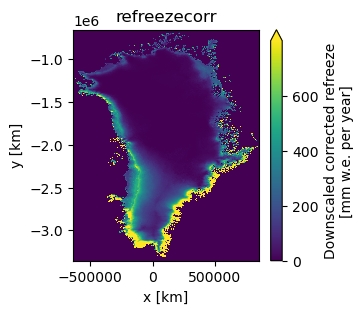

 22%|██▏       | 2/9 [00:15<00:53,  7.71s/it]

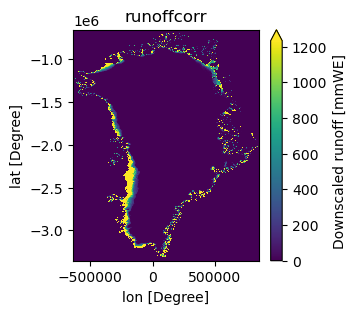

 33%|███▎      | 3/9 [00:20<00:38,  6.41s/it]

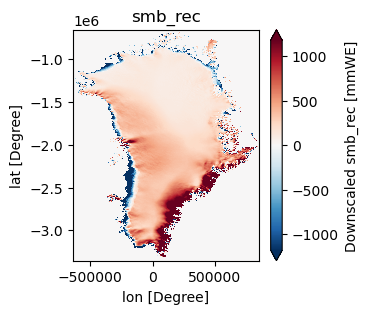

 44%|████▍     | 4/9 [00:28<00:34,  6.98s/it]

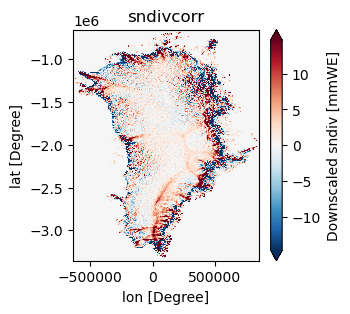

 56%|█████▌    | 5/9 [00:36<00:30,  7.63s/it]

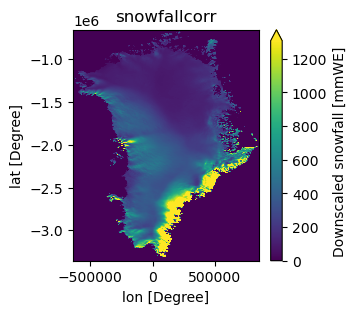

 67%|██████▋   | 6/9 [00:44<00:23,  7.77s/it]

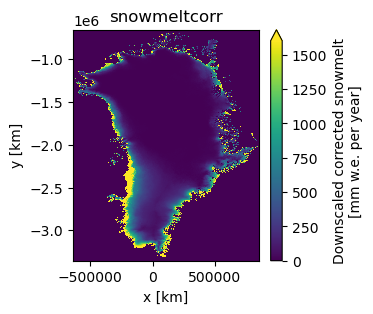

 78%|███████▊  | 7/9 [00:53<00:15,  7.90s/it]

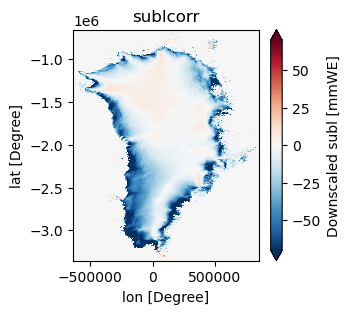

 89%|████████▉ | 8/9 [01:00<00:07,  7.72s/it]

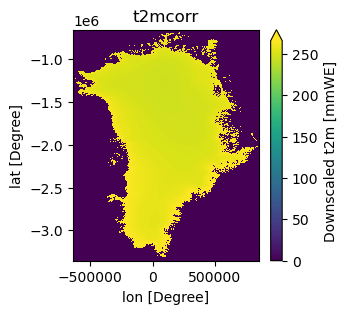

100%|██████████| 9/9 [01:07<00:00,  7.53s/it]


In [11]:

# Example usage:
directory = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/"
datasets = plot_first_timestep_in_directory(directory)


In [16]:
ds_fake = datasets['t2mcorr'].isel(time=0).copy(deep=True)   
ds_fake['Icemask'] = xr.zeros_like(ds_fake['t2mcorr'])+1
ds_fake['Icemask'] = ds_fake['Icemask'].where(ds_fake['t2mcorr']>0)

In [17]:
# all keys in datasets
datasets.keys()

var = 'precipcorr'



In [18]:
def fix_years_since_ref(ds, ref_year=1958):
    # Extract the time values (years since reference)
    years_since_ref = ds['time'].values
    actual_years = ref_year + years_since_ref.astype(int)
    new_dates = np.array([np.datetime64(f'{year}-01-01') for year in actual_years])
    ds['time'] = new_dates
    return ds
    
def fix_days_since_ref(ds, ref_year=1958):
    # Extract the time values (years since reference)
    days_since_ref = ds['time'].values
    actual_years = (ref_year + days_since_ref/365.).astype(int)
    new_dates = np.array([np.datetime64(f'{year}-01-01') for year in actual_years])
    ds['time'] = new_dates
    return ds

def fix_time_since_ref(ds, ref_year=1958):
    # Extract the time values (years since reference)
    if 'units' in ds['time'].attrs:
        units = ds['time'].attrs['units']
    else: 
        units = ""
    if 'DAYS' in units:
        ds = fix_days_since_ref(ds, ref_year)
    elif 'YEARS' in units:
        ds = fix_years_since_ref(ds, ref_year)
    else:
        print("Not converted")
    return ds



In [22]:
dss_mean_per_region = {}

for var in tqdm(datasets.keys()):
    dss_mean_per_region[var] = datasets[var][var].where(ds_fake.Icemask==1).groupby(dsprecipRACMO1kmAnnual['regions']).mean()

  0%|          | 0/9 [00:00<?, ?it/s]

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_25947/2995752937.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = new_dates
/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_25947/2995752937.py:14: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variabl

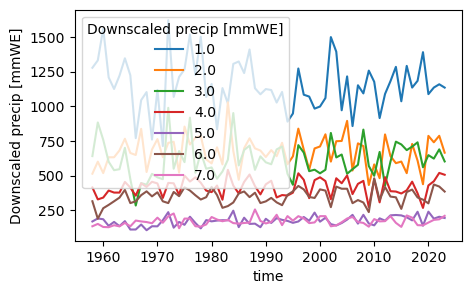

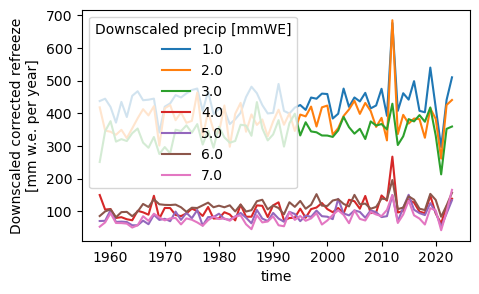

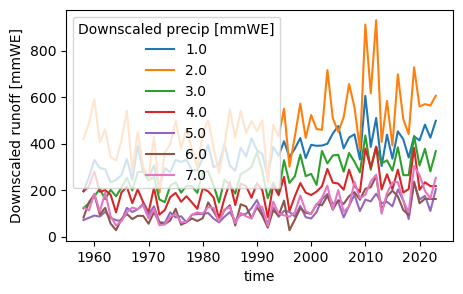

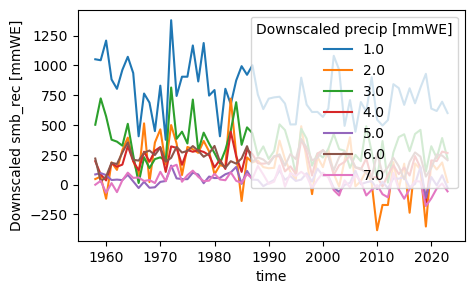

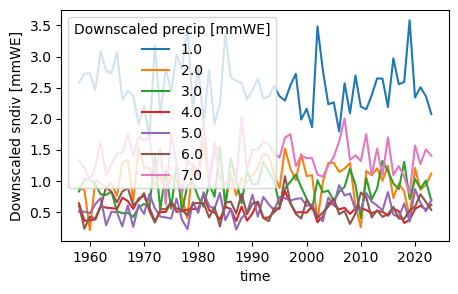

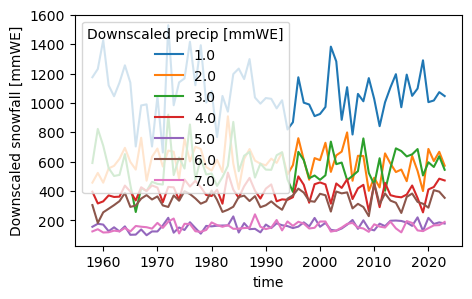

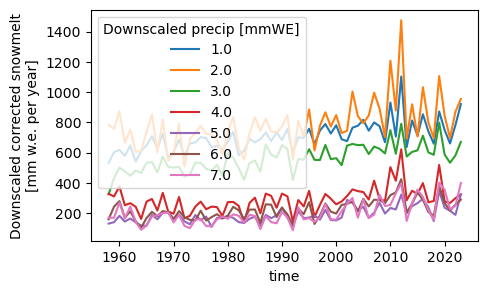

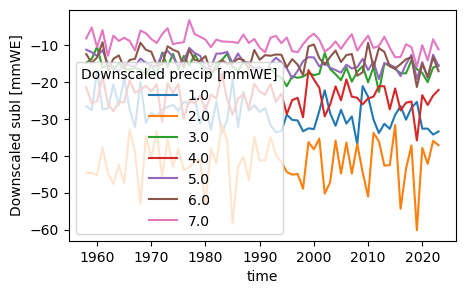

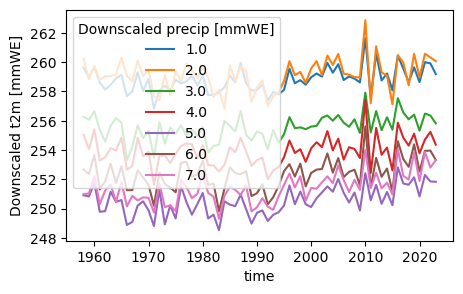

In [23]:
for var in tqdm(dss_mean_per_region.keys()):

    fix_time_since_ref(dss_mean_per_region[var]).plot.line(x='time', figsize=(5,3))
    # plt.show()

In [29]:
df_racmo_vars = pd.DataFrame(index= np.arange(1,8), columns = dss_mean_per_region.keys())

start = '1990-01-01'
end = '2023-01-01'
# select all years since 1990
for var in dss_mean_per_region.keys():
    df_racmo_vars[var] = dss_mean_per_region[var].sel(time=slice(start,end)).mean(dim='time').to_dataframe()
# df_racmo_vars


In [39]:
df_racmo_vars_regions = df_racmo_vars.reset_index()
df_racmo_vars_regions['Basins'] = df_racmo_vars_regions['index'].map(dict_sections)
melt = df_racmo_vars_regions['snowmeltcorr']+(df_racmo_vars_regions['precipcorr']- df_racmo_vars_regions['snowfallcorr'])
acc = df_racmo_vars_regions['snowfallcorr']+df_racmo_vars_regions['sublcorr']
df_racmo_vars_regions['melt_acc'] = melt/acc    # drop column 'index'
df_racmo_vars_regions = df_racmo_vars_regions.drop(columns=['index'])
# df_per_region_rel.rename(columns={'Unnamed: 0':'Basins'}).set_index('Basins').T.index
df_per_region_rel_FW = df_per_region_rel.rename(columns={'Unnamed: 0':'Flux'}).set_index('Flux')
df_per_region_rel_FW.columns.name = 'Basins'
df_per_region_rel_FW = df_per_region_rel_FW.T
df_per_region_rel_FW['SID_GrIS']= df_per_region_rel_FW['Solid Ice Discharge']/df_per_region_rel_FW['Liquid Runoff Ice Sheet']
df_per_region_rel_FW['SID_Tundra']= df_per_region_rel_FW['Solid Ice Discharge']/df_per_region_rel_FW['Liquid Runoff Tundra']
df_racmo_vars_FW_rel = pd.merge(df_racmo_vars_regions.set_index('Basins'),df_per_region_rel_FW, left_index=True, right_index=True)

KeyError: "None of ['Flux'] are in the columns"

In [3]:
df_racmo_vars_regions['melt_acc'] 

NameError: name 'df_racmo_vars_regions' is not defined

In [762]:
df_per_region_rel_FW['Solid Ice Discharge']/df_per_region_rel_FW['Liquid Runoff Ice Sheet']

df_per_region_rel_FW['Solid Ice Discharge']/df_per_region_rel_FW['Liquid Runoff Tundra']

Basins
SE     5.548615
SW     0.364830
CE     3.529496
CW     4.323591
NE     0.857479
NW    19.502641
NO     1.461061
dtype: float64

In [755]:
df_racmo_vars_FW_rel.corr().style.background_gradient(cmap='PiYG_r', vmin=-1, vmax=1).set_caption("Title").format("{:.2f}")


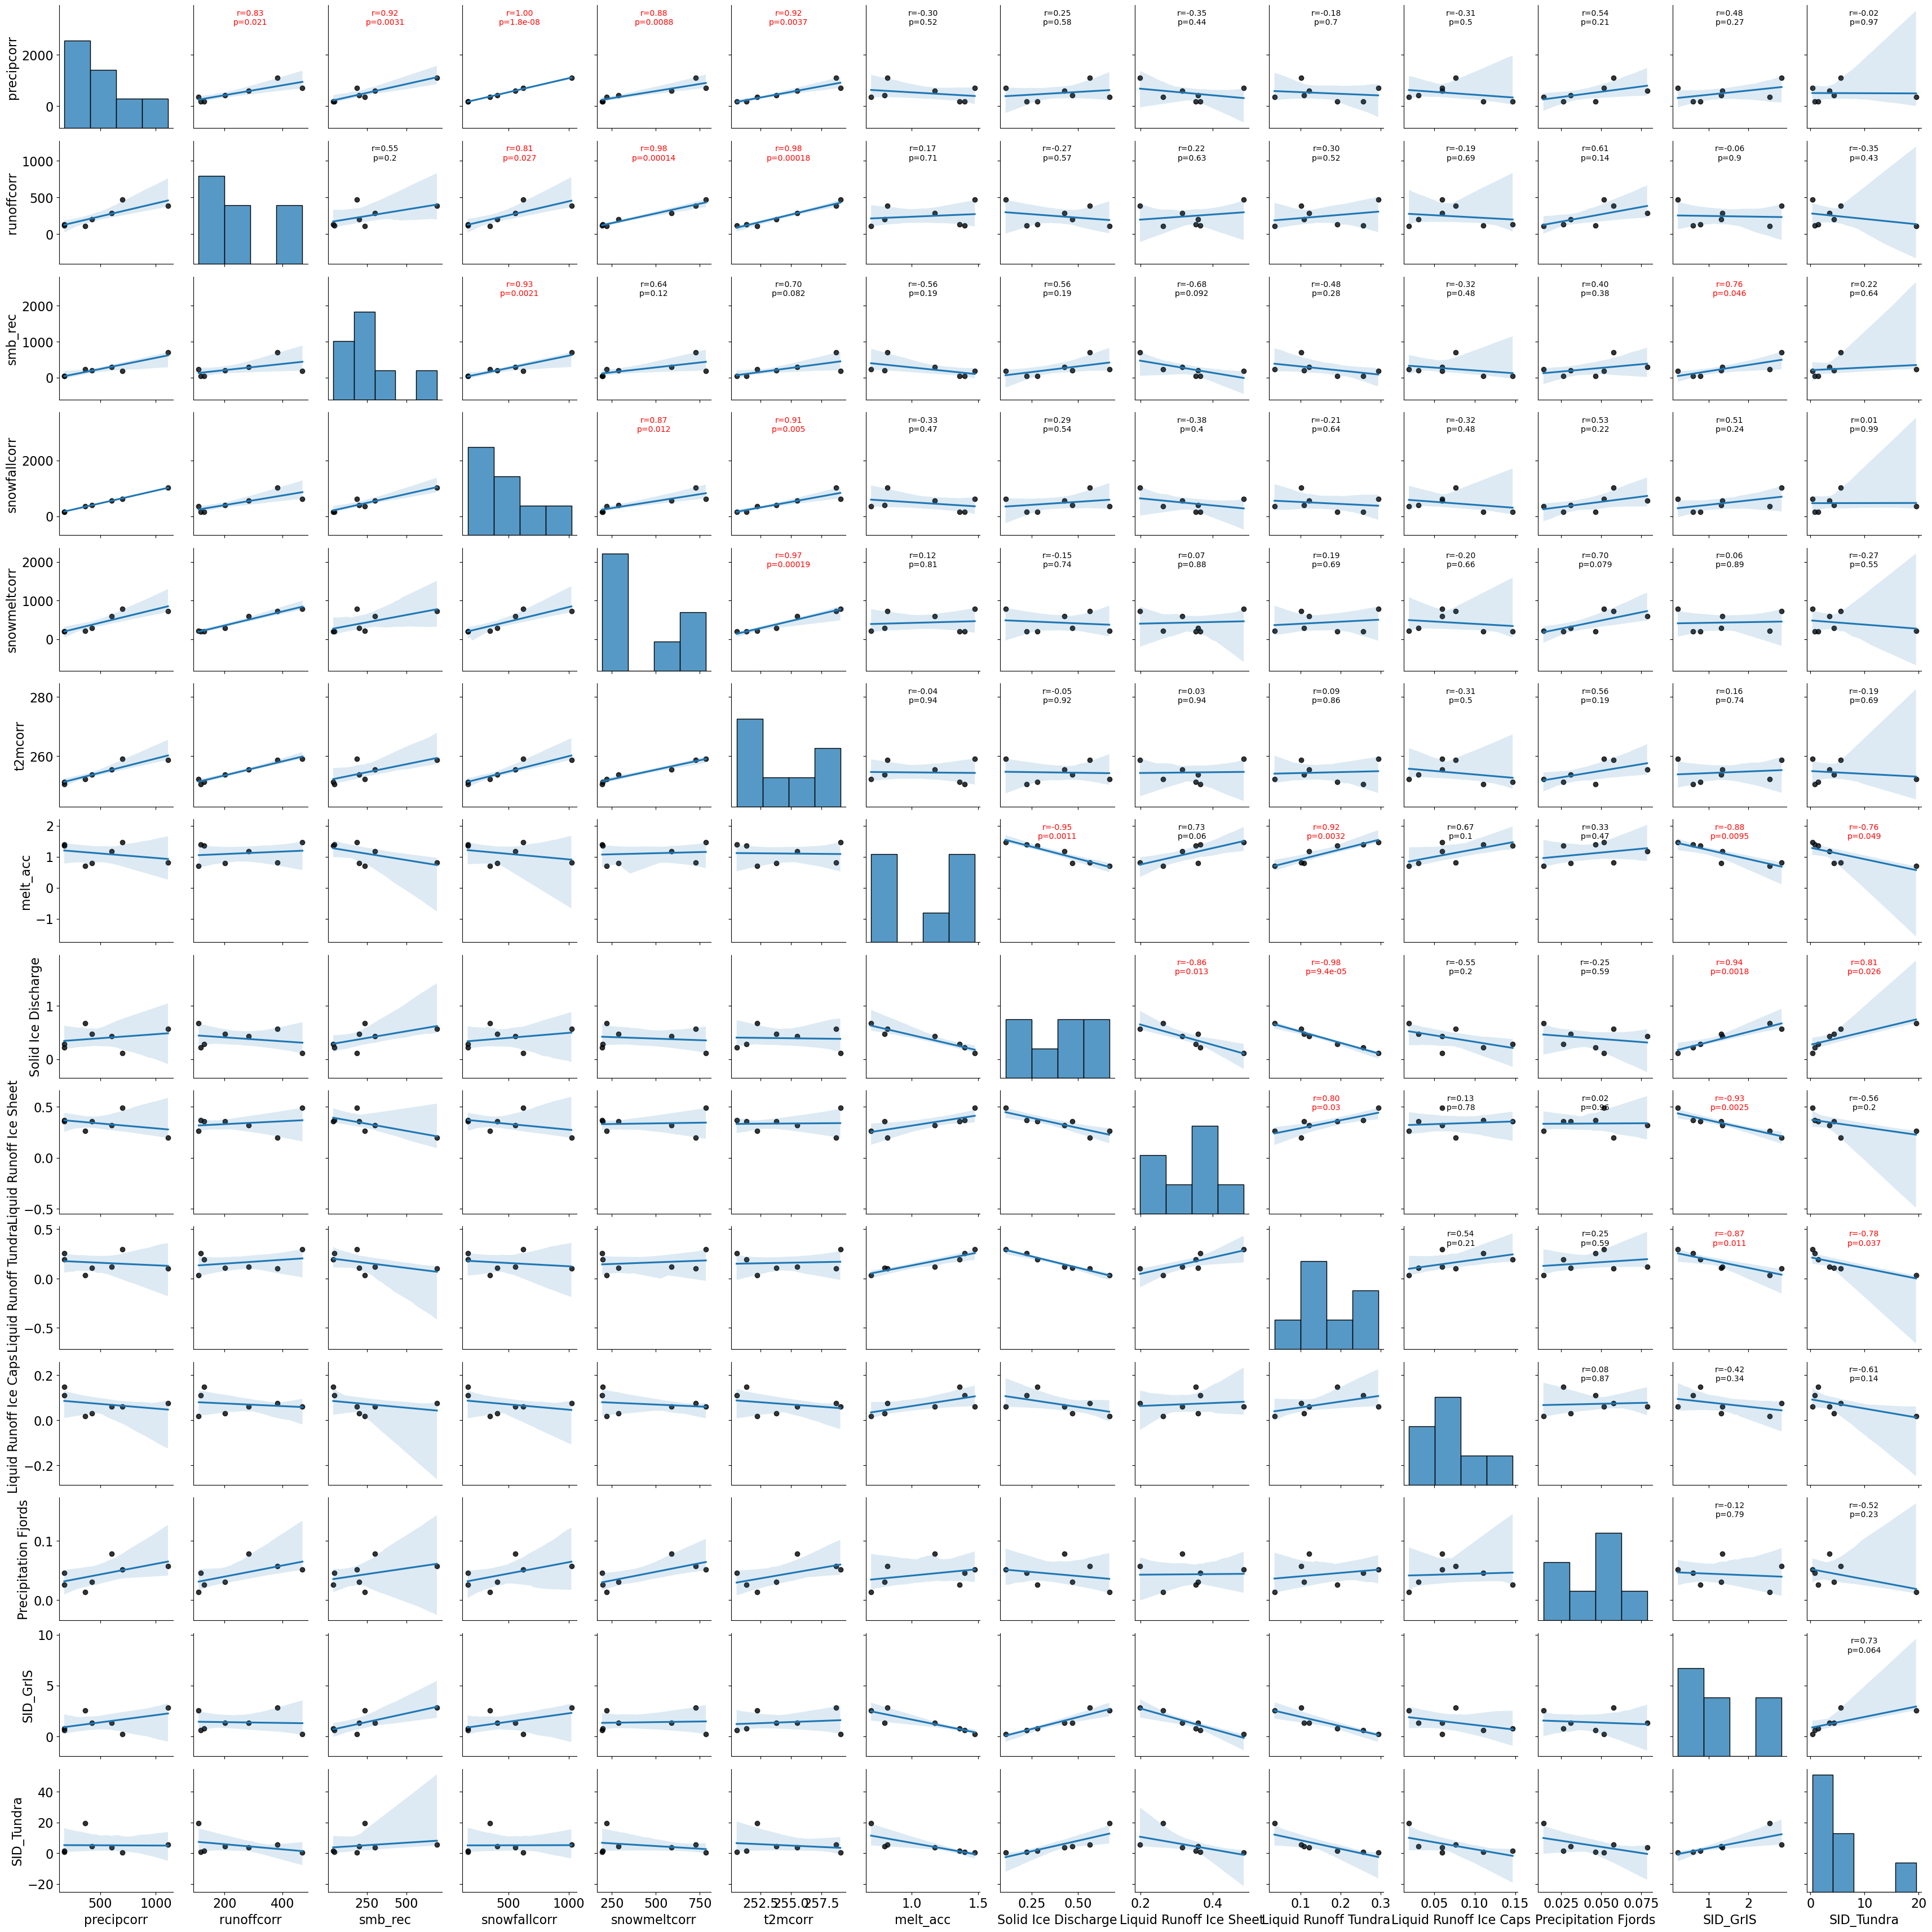

: 

In [765]:
# set rcparameters fontsize
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})

fig = create_pair_plot(df_racmo_vars_FW_rel[['precipcorr', 'runoffcorr', 'smb_rec',
       'snowfallcorr', 'snowmeltcorr', 't2mcorr', 'melt_acc',
       'Solid Ice Discharge', 'Liquid Runoff Ice Sheet',
       'Liquid Runoff Tundra', 'Liquid Runoff Ice Caps',
       'Precipitation Fjords','SID_GrIS', 'SID_Tundra']])

#  increase fontsize  sns


In [698]:
fig

In [629]:
df_racmo_vars_regions.round()

index  precipcorr  refreezecorr  runoffcorr  smb_rec  sndivcorr  \
0      1      1209.0         391.0       359.0    614.0        2.0   
1      2       777.0         284.0       387.0     63.0        1.0   
2      3       656.0         303.0       266.0    252.0        1.0   
3      4       435.0          96.0       193.0    137.0        0.0   
4      5       229.0          79.0       113.0     27.0        1.0   
5      6       362.0         118.0       135.0    189.0        0.0   
6      7       187.0          65.0       122.0     -1.0        1.0   

   snowfallcorr  snowmeltcorr  sublcorr  t2mcorr Basins  
0         972.0         673.0     -27.0    230.0     SE  
1         439.0         618.0     -30.0    189.0     SW  
2         529.0         529.0     -15.0    221.0     CE  
3         340.0         273.0     -20.0    214.0     CW  
4         150.0         182.0     -13.0    209.0     NE  
5         326.0         239.0     -14.0    240.0     NW  
6         124.0         178.0      -8.0    187.0     NO

In [630]:
df_racmo_vars_regions['refreezecorr']+ df_racmo_vars_regions['runoffcorr']

0    750.406372
1    671.482666
2    569.105347
3    288.823059
4    191.960327
5    253.547333
6    186.890228
dtype: float32

In [627]:
df_racmo_vars_regions['P_S_div_snowmelt'] = (df_racmo_vars_regions['precipcorr']+df_racmo_vars_regions['sublcorr'])/df_racmo_vars_regions['snowmeltcorr']

0    1.756394
1    1.208978
2    1.212896
3    1.520645
4    1.188175
5    1.457057
6    1.011294
dtype: float32

In [ ]:

df_mean_precip_abs_flux = pd.merge(df_per_region_abs, dfprecipRACMO1kmAnnual_sum_region)
df_abs = df_mean_precip_abs_flux.set_index(['precipcorr', 'Basins']).stack().reset_index().rename(columns={'level_2':'FW component', 0:'Flux'})

# for both drop column 'regions'
# df_abs = df_abs.drop(columns=['regions'])


In [707]:
directory = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/Annual/"
datasets = plot_first_timestep_in_directory(directory)


TypeError: No numeric data to plot.

In [717]:
var = 'snowmelt'
df_runoff_55 = xr.open_mfdataset(f'/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/Annual/{var}_yearlyS_FGRN055_BN_RACMO2.3p2_ERA5_3h_1940_FGRN055_1940_1950.nc')

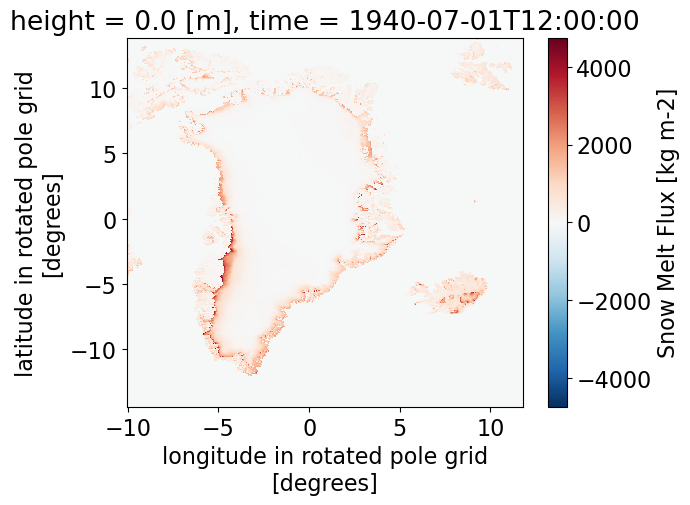

In [718]:
df_runoff_55[var].isel(time=0).plot()